### References:
* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

### TODO:
* Understand the Augmented Dickey-Fuller unit root test for stationarity of the time series
> If $x(t) = \rho x(t-1) + Er(t)$ with $\rho < 1$, $x(t)$ is pushed back to zero and the series is stationary; if $\rho=1$, the series drifts away and is non-stationary. So, this test essentially consists of trying an auto-regression for $y(t) = x(t) - x(t-1) = (\rho-1) x(t-1) + Er(t)$ and testing the null hypothesis $\gamma = \rho - 1 = 0$.
* Confirm if ARIMA is really "just" a linear regression over $x[t-i]$, $error[t-i]$ and how the differences actually enter into the equation
> Regarding **differencing**: whenever differencing is used to stationarize a time series, the ARIMA model's parameter $d$ is the "differencing order" used.  
> **MA model**: linear regression of $x(t)$ as a function of a white noise process $error(t-i)$, $i=1,2,...,q$  
> **AR model**: linear regression of $x(t)$ as a function of $x(t-i)$, $i=1,2,...p$
* Understand how autocorrelation and partial autocorrelation plots are enough to find optimal values for $p$ and $q$ of an ARIMA model
> **autocorrelation**: by design, MA models have no autocorrelation for lags $\Delta t > q$; therefore, a cut-off in autocorrelation may be related to a good choice of $q$  
> **partial autocorrelation**: by design, the autocorrelation of AR models is fully explained using only lags $\Delta t \leq p$; therefore, a cut-off in partial autocorrelation may be related to a good choice of $p$
* Review this notebook in light of what I learn
* Study more sophisticated methods to make a non-stationary series stationary
* Calculate the autocorrelations of processes described by MA and AR models; later, consider a ARMA process

In [1]:
%load_ext autotime

In [4]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette('pastel')

time: 10.5 ms


ADF test results:
adf                        0.815369
p-value                    0.991880
#lags                     13.000000
#obs                     130.000000
critical values (1%)      -3.481682
critical values (5%)      -2.884042
critical values (10%)     -2.578770
dtype: float64
ADF test results:
adf                       -2.717131
p-value                    0.071121
#lags                     14.000000
#obs                     128.000000
critical values (1%)      -3.482501
critical values (5%)      -2.884398
critical values (10%)     -2.578960
dtype: float64


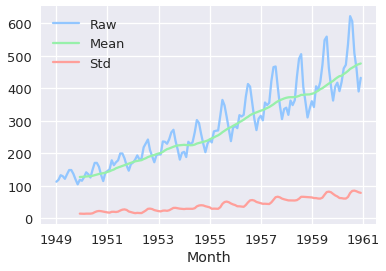

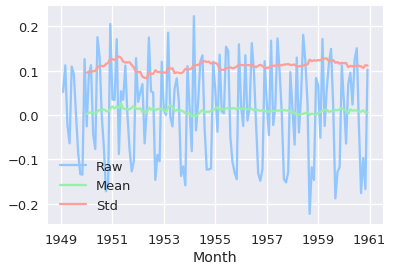

time: 1.82 s


In [3]:
def load_data():
    date_parser = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
    return pd.read_csv('../data/raw/AirPassengers.csv', index_col='Month',
                       parse_dates=['Month'], date_parser=date_parser)['#Passengers']\
             .sort_index()

def test_stationarity(ts, window=12):
    rolling_mean = ts.rolling(window).mean()
    rolling_std = ts.rolling(window).std()
    fig, ax = plt.subplots()
    ts.plot(ax=ax, label='Raw')
    rolling_mean.plot(ax=ax, label='Mean')
    rolling_std.plot(ax=ax, label='Std')
    plt.legend(loc='best')
    *adf_test, critical_values, icbest = adfuller(ts)
    print('ADF test results:')
    print(pd.Series(data=list(adf_test) + list(critical_values.values()),
                    index=['adf', 'p-value', '#lags', '#obs'] +\
                          ['critical values ({})'.format(key) for key in critical_values.keys()]))
    
def remove_trend_and_seasonality(ts):
    ts_log = np.log(ts)
    return ts_log - ts_log.shift()
    
passengers = load_data()
test_stationarity(passengers)
treated_passengers = remove_trend_and_seasonality(passengers).dropna()
test_stationarity(treated_passengers)

In [5]:
lag_acf = acf(treated_passengers, nlags=20)
lag_pacf = pacf(treated_passengers, nlags=20, method='ols')

time: 30.2 ms


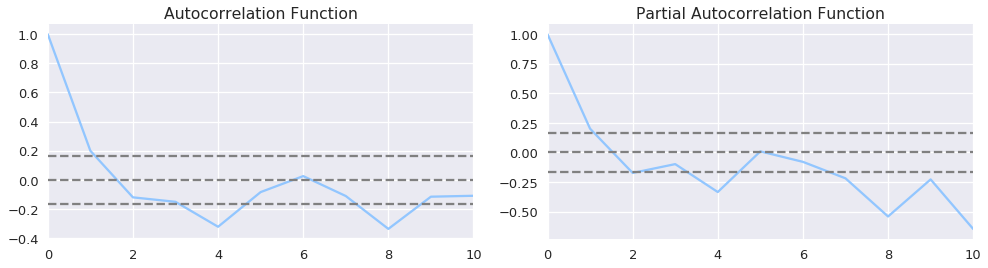

time: 251 ms


In [7]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(treated_passengers)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(treated_passengers)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.xlim(0, 10)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(treated_passengers)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(treated_passengers)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlim(0, 10)
plt.tight_layout()

/home/felipe/.miniconda3/envs/time-series/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/felipe/.miniconda3/envs/time-series/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/felipe/.miniconda3/envs/time-series/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtyp

Text(0.5,1,'RSS: 1.0292 (d=1)')

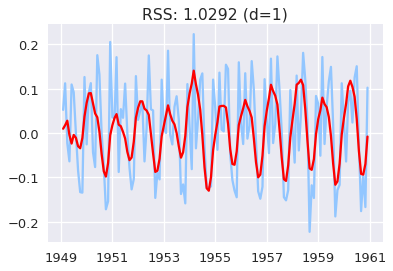

time: 514 ms


In [11]:
model = ARIMA(np.log(passengers).dropna(), order=(2, 1, 2))
results_ARIMA = model.fit()
plt.plot(treated_passengers)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f (d=1)'% sum((results_ARIMA.fittedvalues - treated_passengers)**2))

Text(0.5,1,'RMSE: 90.1046')

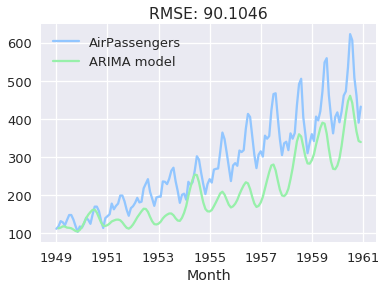

time: 198 ms


In [13]:
passengers.plot(label='AirPassengers')
pred_ARIMA.plot(label='ARIMA model')
plt.legend(loc='best')
rmse = np.sqrt(((pred_ARIMA - passengers)**2).sum() / len(passengers))
plt.title('RMSE: %.4f'% rmse)